# Transak iteration 1

- Wide and Deep Neural Network using Keras functional API (multiple Input Layers).
- Feature Engineering with Lambda Layers.
- Lessons learned after implementing old feature_column API and DenseFeature

## Imports

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(f"BigQuery client library version: {bigquery.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

BigQuery client library version: 3.24.0
Pandas version: 2.2.2
Tensorflow version: 2.17.0
Keras version: 3.10.0
Matplotlib version: 3.9.0


## Data Load

In [2]:
bq = bigquery.Client(project="af-finanzen")
query = """
  WITH EDA AS (
    SELECT
        tid
      , type
      , EXTRACT(YEAR  FROM started) AS started_year
      , EXTRACT(MONTH FROM started) AS started_month
      , EXTRACT(DAY   FROM started) AS started_day
      , MOD(EXTRACT(DAYOFWEEK FROM started) + 5, 7) AS started_weekday
      , EXTRACT(YEAR  FROM first_started) AS first_started_year
      , EXTRACT(MONTH FROM first_started) AS first_started_month
      , EXTRACT(DAY   FROM first_started) AS first_started_day
      , MOD(EXTRACT(DAYOFWEEK FROM first_started) + 5, 7) AS first_started_weekday
      , LOWER(description) description -- i1_eda_conclusion_2
      , amount
      --, fee
      , currency
      --, state
      --, account
      , CASE
          WHEN i1_true_label = 'PK Prezenty' THEN 'PK Rest'
          WHEN i1_true_label = 'PK Auto' THEN 'PK Rest'
          WHEN i1_true_label = 'Apt' THEN 'PK Kasia'
          ELSE i1_true_label
        END AS i1_true_label
    FROM `af-finanzen.monatsabschluss.revolut_abrechnung`
    WHERE
      type NOT IN ("FEE", "ATM") -- i1_eda_conclusion_1 - too few data
      -- AND ABS(amount) < 500 -- i1_eda_conclusion_3 remove outliers
    ORDER BY started
  ),
  LABEL_INT AS (
    SELECT
      *
      , DENSE_RANK() OVER(ORDER BY i1_true_label) - 1 AS i1_true_label_id
    FROM EDA
  ),
  SPLIT_SET AS (
    SELECT
        tid
      , i1_true_label
      , CASE
          WHEN ABS(MOD(tid, 10)) <= 7 THEN 'train'
          WHEN ABS(MOD(tid, 10)) = 8 THEN 'validation'
          WHEN ABS(MOD(tid, 10)) = 9 THEN 'test'
          -- WHEN ABS(MOD(tid, 100)) < 60 THEN 'train'
          -- WHEN ABS(MOD(tid, 100)) BETWEEN 60 AND 80 THEN 'validation'
          -- WHEN ABS(MOD(tid, 100)) BETWEEN 80 AND 100 THEN 'test'
          ELSE "unknown"
        END AS split_set
    FROM EDA
    GROUP BY
      i1_true_label, tid
  )
  SELECT
    LABEL_INT.* EXCEPT(tid)
    , SPLIT_SET.split_set
  FROM LABEL_INT
  JOIN SPLIT_SET
  ON LABEL_INT.tid = SPLIT_SET.tid
"""
df = bq.query(query).to_dataframe()
df.i1_true_label.value_counts()

c:\Users\admin\git\arturroo\af-finanzen\jupiter\transak\i1\keras_functional_api\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


i1_true_label
Top-Up         751
PK Leben       412
PK Reisen      352
PK Artur       208
SK Ferien      205
PK Maja        143
eShop          141
PK Abo         124
PK Medic        84
SK Haushalt     55
PK Kasia        41
Exchange        32
PK Rest         28
Name: count, dtype: int64

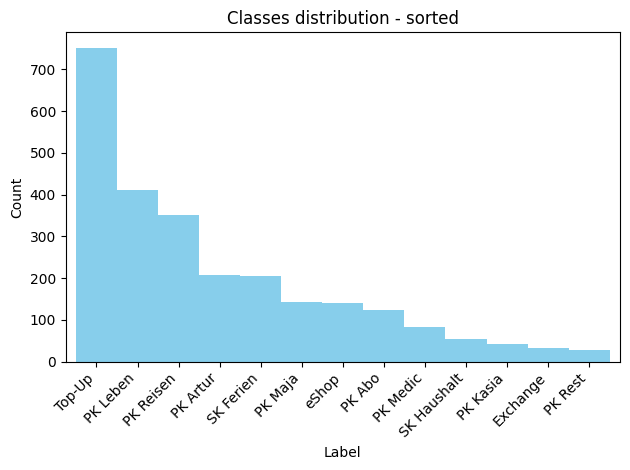

In [3]:
df.i1_true_label.value_counts().plot(kind="bar", width=1, color="skyblue")
plt.ylabel("Count")
plt.xlabel("Label")
plt.title("Classes distribution - sorted")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [4]:
df.dtypes

type                      object
started_year               Int64
started_month              Int64
started_day                Int64
started_weekday            Int64
first_started_year         Int64
first_started_month        Int64
first_started_day          Int64
first_started_weekday      Int64
description               object
amount                   float64
currency                  object
i1_true_label             object
i1_true_label_id           Int64
split_set                 object
dtype: object

In [5]:
df.type.value_counts()

type
CARD_PAYMENT    1582
TOPUP            748
TRANSFER         175
CARD_REFUND       39
EXCHANGE          32
Name: count, dtype: int64

Ngram max count

In [6]:
df['description'].str.split().str.len().describe()

count    2576.000000
mean        2.301242
std         1.220574
min         1.000000
25%         1.000000
50%         3.000000
75%         3.000000
max        10.000000
Name: description, dtype: float64

## Reverse label name to id mapping

In [7]:
rev_mapping_df = df.pop("i1_true_label")
rev_mapping_df = pd.concat([rev_mapping_df, df.i1_true_label_id], axis=1)
rev_mapping_df = (rev_mapping_df
                  .drop_duplicates()
                  .sort_values(by='i1_true_label_id')
                  .reset_index(drop=True))

class_names=rev_mapping_df.i1_true_label.tolist()

rev_mapping_df

,i1_true_label,i1_true_label_id
0,Exchange,0
1,PK Abo,1
2,PK Artur,2
3,PK Kasia,3
4,PK Leben,4
5,PK Maja,5
6,PK Medic,6
7,PK Reisen,7
8,PK Rest,8
9,SK Ferien,9


## Train, test, validation split

In [8]:
train_df = df[df['split_set'] == 'train'].drop(columns=['split_set'])
test_df = df[df['split_set'] == 'test'].drop(columns=['split_set'])
val_df = df[df['split_set'] == 'validation'].drop(columns=['split_set'])
print(df.shape, 'all examples and columns')
print(len(train_df), 'train examples')
print(len(test_df), 'test examples')
print(len(val_df), 'validation examples')
print(train_df.i1_true_label_id.value_counts())

(2576, 14) all examples and columns
2089 train examples
250 test examples
237 validation examples
i1_true_label_id
11    608
4     336
7     283
2     168
9     167
5     120
12    115
1     100
6      68
10     45
3      31
0      27
8      21
Name: count, dtype: Int64


## Transform Pandas DF into Tensorflow Dataset

In [9]:
def df2dataset(df: pd.DataFrame, shuffle=True, batch_size=16):
    df = df.copy()
    labels = df.pop("i1_true_label_id").astype(np.int64)
    for col in df.columns:
        if isinstance(df[col].dtype, pd.Int64Dtype):
            # It's often safest to convert feature columns to float32,
            # as it naturally handles potential missing values if you need them.
            # also solves ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).
            print(f"Converting feature column '{col}' from Int64 to float32.")
            df[col] = df[col].astype(np.float32)
        elif isinstance(df[col].dtype, pd.Float64Dtype):
            print(f"Converting feature column '{col}' from Float64 to float32.")
            df[col] = df[col].astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels), name="i1_dataset")
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    # ds.map(lambda...) MLE 4.3.2
    ds = ds.batch(batch_size=batch_size)
    return ds

In [10]:
train_ds = df2dataset(train_df, batch_size=32)
val_ds = df2dataset(val_df, batch_size=16)
for feature_batch, label_batch in train_ds.take(1):
    print(f'List of feature names: {list(feature_batch.keys())}')
    print(f'Batch of type: {feature_batch["type"]}')
    print(f'Batch of labels: {label_batch}')

Converting feature column 'started_year' from Int64 to float32.
Converting feature column 'started_month' from Int64 to float32.
Converting feature column 'started_day' from Int64 to float32.
Converting feature column 'started_weekday' from Int64 to float32.
Converting feature column 'first_started_year' from Int64 to float32.
Converting feature column 'first_started_month' from Int64 to float32.
Converting feature column 'first_started_day' from Int64 to float32.
Converting feature column 'first_started_weekday' from Int64 to float32.
Converting feature column 'started_year' from Int64 to float32.
Converting feature column 'started_month' from Int64 to float32.
Converting feature column 'started_day' from Int64 to float32.
Converting feature column 'started_weekday' from Int64 to float32.
Converting feature column 'first_started_year' from Int64 to float32.
Converting feature column 'first_started_month' from Int64 to float32.
Converting feature column 'first_started_day' from Int64 t

In [11]:
print(train_ds.element_spec[0])

{'type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'started_year': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'started_month': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'started_day': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'started_weekday': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'first_started_year': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'first_started_month': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'first_started_day': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'first_started_weekday': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'description': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'amount': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'currency': TensorSpec(shape=(None,), dtype=tf.string, name=None)}


# Input

In [12]:
# Cyclical features
cyclic_inputs = {}
cyclic_inputs['started_month'] = tf.keras.Input(shape=(1,), name="started_month", dtype="float32")
cyclic_inputs['started_day'] = tf.keras.Input(shape=(1,), name="started_day", dtype="float32")
cyclic_inputs['started_weekday'] = tf.keras.Input(shape=(1,), name="started_weekday", dtype="float32")
cyclic_inputs['first_started_month'] = tf.keras.Input(shape=(1,), name="first_started_month", dtype="float32")
cyclic_inputs['first_started_day'] = tf.keras.Input(shape=(1,), name="first_started_day", dtype="float32")
cyclic_inputs['first_started_weekday'] = tf.keras.Input(shape=(1,), name="first_started_weekday", dtype="float32")
# Numerical features
numeric_inputs = {}
numeric_inputs['started_year'] = tf.keras.Input(shape=(1,), name="started_year", dtype="float32")
numeric_inputs['first_started_year'] = tf.keras.Input(shape=(1,), name="first_started_year", dtype="float32")
numeric_inputs['amount'] = tf.keras.Input(shape=(1,), name="amount", dtype="float64")
# Text features
text_inputs = {}
text_inputs['type'] = tf.keras.Input(shape=(1,), name="type", dtype="string")
text_inputs['currency'] = tf.keras.Input(shape=(1,), name="currency", dtype="string")
text_inputs['description'] = tf.keras.Input(shape=(1,), name="description", dtype="string")

print(cyclic_inputs)
print(numeric_inputs)
print(text_inputs)

{'started_month': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=started_month>, 'started_day': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=started_day>, 'started_weekday': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=started_weekday>, 'first_started_month': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=first_started_month>, 'first_started_day': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=first_started_day>, 'first_started_weekday': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=first_started_weekday>}
{'started_year': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=started_year>, 'first_started_year': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=first_started_year>, 'amount': <KerasTensor shape=(None, 1), dtype=float64, sparse=Fals

# Feature Engineering

## First level Lambda Layers

Time cyclic transformations (sin, cos) to catch periodic abos and subscriptions

In [13]:
@tf.keras.utils.register_keras_serializable()
class CyclicalFeature(layers.Layer):
    """
    A custom Keras layer to perform sin/cos cyclical transformation.
    Outputs a tensor with two features: [sin_value, cos_value].
    """
    def __init__(self, period, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        # We store the period as part of the layer's configuration.
        self.period = float(period)

    def call(self, inputs):
        """Feature transformation logic."""
        # We handle the logic for 0-based weekdays vs. 1-based days/months for sin/cos to catch the cyclical nature. If not then 1 is faraway from 0, which is far from 12 or 31
        adjusted_inputs = inputs if self.period == 7.0 else inputs - 1
        
        # Calculate sin and cos transformations
        sin_transformed = tf.math.sin(2 * np.pi * adjusted_inputs / self.period)
        cos_transformed = tf.math.cos(2 * np.pi * adjusted_inputs / self.period)
        
        # Concatenate the results into a single output tensor of shape (None, 2)
        return layers.concatenate([sin_transformed, cos_transformed], axis=-1)

    def get_config(self):
        """Save and load the layer correctly."""
        config = super().get_config()
        config.update({"period": self.period})
        return config

In [14]:
cyclical_features = {}
# Started Date Features
cyclical_features["started_month"] = CyclicalFeature(period=12, name='started_month_cyclical')(cyclic_inputs['started_month'])
cyclical_features["started_day"] = CyclicalFeature(period=31, name='started_day_cyclical')(cyclic_inputs['started_day'])
cyclical_features["started_weekday"] = CyclicalFeature(period=7, name='started_weekday_cyclical')(cyclic_inputs['started_weekday'])

# First Started Date Features
cyclical_features["first_started_month"] = CyclicalFeature(period=12, name='first_started_month_cyclical')(cyclic_inputs['first_started_month'])
cyclical_features["first_started_day"] = CyclicalFeature(period=31, name='first_started_day_cyclical')(cyclic_inputs['first_started_day'])
cyclical_features["first_started_weekday"] = CyclicalFeature(period=7, name='first_started_weekday_cyclical')(cyclic_inputs['first_started_weekday'])

amount log - to show better several transactions that are far from average and are not outliers

amount sign - to indicate money flow in and out of Revolut account in addition to type column

In [15]:
@tf.keras.utils.register_keras_serializable()
class AmountFeatures(layers.Layer):
    """
    A custom layer to create log and sign features from an amount input.
    Outputs a tensor: [log1p_abs_amount, sign_flag].
    """
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs):
        """The feature transformation logic."""
        # 1. The robust log transform
        log1p_abs_amount = tf.math.log1p(tf.abs(inputs))
        
        # 2. The binary sign feature
        sign_flag = tf.cast(inputs >= 0, dtype=tf.float32)

        # 3. Concatenate the results and return them as a single tensor
        return layers.concatenate([log1p_abs_amount, sign_flag], axis=-1)

    def get_config(self):
        # This layer has no custom arguments in __init__, so we just call the parent
        config = super().get_config()
        return config

In [16]:
amount_transformed = AmountFeatures(name='amount_features')(numeric_inputs['amount'])

## Second Level - Memorization - Wide Layers

description transformed into categorical hash bins. Number of bins about 2 times bigger then number of unique descriptions.
This should allow new, unseen description have their own place in this feature.

In [17]:
description_hash_bins = 1000
description_hash = layers.Hashing(
    num_bins=description_hash_bins, 
    #mask_value=0,
    output_mode="int", 
    name="description_hash"
)(text_inputs["description"])
description_hash

<KerasTensor shape=(None, 1), dtype=int64, sparse=False, ragged=False, name=keras_tensor_8>

Column type transformed into categorical standard layer with adapt.

In [18]:
type_lookup_layer = layers.StringLookup(
    num_oov_indices=2, 
    # vocabulary=type_lookup_vocab, 
    output_mode="int", 
    name="type_lookup"
)
type_lookup_layer.adapt(train_ds.map(lambda features, labels: features["type"]))
type_lookup_vocab_size = type_lookup_layer.vocabulary_size()
print(f"Type lookup vocabulary size: {type_lookup_vocab_size}")
type_lookup = type_lookup_layer(text_inputs["type"])
type_lookup


Type lookup vocabulary size: 7


<KerasTensor shape=(None, 1), dtype=int64, sparse=False, ragged=False, name=keras_tensor_9>

feature cross of type and description in order to show if this and this than that. EDA has shown corelation between those two columns.

In [19]:
type_desc_cross_num_bins = description_hash_bins * type_lookup_vocab_size
type_desc_cross = layers.HashedCrossing(num_bins=type_desc_cross_num_bins, output_mode="int", name="type_desc_cross")([description_hash, type_lookup])
type_desc_cross_num_bins

7000

Transform feature cross into wide sparse vector for linear model

In [20]:
wide_one_hot = layers.CategoryEncoding(num_tokens=type_desc_cross_num_bins + 1, output_mode="one_hot", name="wide_one_hot")(type_desc_cross)

Head of wide linear model without non-linear activation

In [21]:
wide_logits_neurons = len(rev_mapping_df.i1_true_label)
wide_logits = layers.Dense(units=wide_logits_neurons, activation=None)(wide_one_hot)
wide_logits

<KerasTensor shape=(None, 13), dtype=float32, sparse=False, ragged=False, name=keras_tensor_12>

## Second Level - Generalization - Deep Layers

### Free text transformation of description column

description - text vectorization layer with ngrams, then adapt and after that build tensor 

In [22]:
desc_text_vec_max_tokens = 5000
desc_text_vec_layer = layers.TextVectorization(
    max_tokens=desc_text_vec_max_tokens,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=(1,3),
    output_mode="int",
    # output_sequence_length=100,
    name="desc_text_vec")
desc_text_vec_layer.adapt(train_df["description"].values)
desc_text_vec = desc_text_vec_layer(text_inputs["description"])

description - embeddings - to make dense vector from variable ngrams number

In [23]:
desc_embedding_odim = 32
desc_embedding = layers.Embedding(
    input_dim=desc_text_vec_max_tokens + 1,
    output_dim=desc_embedding_odim,
    mask_zero=True,
    name="desc_embedding"
)(desc_text_vec)
desc_embedding

<KerasTensor shape=(None, None, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_14>

description - global average pooling - to remove variable ngram number and have all vectors same length

In [24]:
desc_vec = layers.GlobalAveragePooling1D(name="desc_vec")(desc_embedding)
desc_vec

<KerasTensor shape=(None, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_16>

### Categorical columns transformations - type and currency

I take the type from wide tower and put it in the embedding in order to get short vector

In [25]:
type_embedding_odim = 4
type_embedding = layers.Embedding(
    input_dim=type_lookup_vocab_size,
    output_dim=type_embedding_odim,
    mask_zero=False,
    name="type_embedding"
)(type_lookup)

type_embedding_flat = layers.Flatten(name="type_embedding_flat")(type_embedding)
type_embedding_flat

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

Currency

In [26]:
currency_lookup_layer = layers.StringLookup(
    num_oov_indices=1,
    # vocabulary=curency_lookup_vocab,
    output_mode="int",
    name="currency_lookup"
)
currency_lookup_layer.adapt(train_ds.map(lambda features, labels: features["currency"]))
currency_lookup_vocab_size = currency_lookup_layer.vocabulary_size()
currency_lookup = currency_lookup_layer(text_inputs["currency"])

currency_embedding_odim = 3
currency_embedding = layers.Embedding(
    input_dim=currency_lookup_vocab_size,
    output_dim=currency_embedding_odim,
    mask_zero=False,
    name="currency_embedding"
)(currency_lookup)

currency_embedding_flat = layers.Flatten(name="currency_embedding_flat")(currency_embedding)
currency_embedding_flat

<KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>

### Standarization of numerical features

Concatenate numerical features into one vector

In [27]:
nums_concated = layers.concatenate([
    numeric_inputs["started_year"],
    numeric_inputs["first_started_year"],
    amount_transformed
], name="nums_concat")

Standarization with Normalization

In [28]:
normalizer = layers.Normalization(name="normalizer")
train_df_nums_for_adapt = train_df.copy()
train_df_nums_for_adapt["amount_log"] = np.log1p(np.abs(train_df_nums_for_adapt["amount"]))
train_df_nums_for_adapt["amount_sign"] = (train_df_nums_for_adapt["amount"] >= 0).astype(np.float32)
normalization_training_data = train_df_nums_for_adapt[[
    "started_year",
    "first_started_year",
    "amount_log",
    "amount_sign"
]].values
normalizer.adapt(normalization_training_data)
nums_scaled = normalizer(nums_concated)
nums_scaled

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_23>

Concatenate untouched cyclic features

In [29]:
nums_vec = layers.concatenate([nums_scaled] + list(cyclical_features.values()), name="nums_vec")
nums_vec

<KerasTensor shape=(None, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_24>

### Deep tower features
Final features tensor for generalization

In [30]:
deep_features_head = layers.concatenate([
    desc_vec,
    type_embedding_flat,
    currency_embedding_flat,
    nums_vec
], name="deep_features")
deep_features_head

<KerasTensor shape=(None, 55), dtype=float32, sparse=False, ragged=False, name=keras_tensor_25>

### Deep tower hidden layers - brain of the model

In [31]:
h1 = layers.Dense(units=64, activation="relu", name="h1")(deep_features_head)
drop1 = layers.Dropout(rate=0.2, name="drop1")(h1)
h2 = layers.Dense(units=32, activation="relu", name="h2")(drop1)
h2

<KerasTensor shape=(None, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>

In [32]:
deep_logits = layers.Dense(units=len(rev_mapping_df.i1_true_label), activation=None, name="deep_logits")(h2)
deep_logits

<KerasTensor shape=(None, 13), dtype=float32, sparse=False, ragged=False, name=keras_tensor_29>

# Third level - final logits for multiclass classification

In [33]:
combined_logits = layers.Add(name="combined_logits")([wide_logits, deep_logits])
combined_logits

<KerasTensor shape=(None, 13), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>

In [34]:
final_output = layers.Activation( "softmax", name="final_output")(combined_logits)

# Adaptation
Any preprocessing layer that needs to learn something from your training data to know how to transform future data needs to be .adapt()-ed first.

- TextVectorization: Needs to learn the vocabulary (which word or n-gram maps to which integer).
- StringLookup:      Needs to learn its vocabulary (which category string maps to which integer).
- Normalization:     Needs to learn the mean and standard deviation of the data.

A "stateless" layer like Hashing doesn't need .adapt() because it's a pure mathematical function that doesn't depend on the data it has seen before.

# The Model

In [35]:
model = tf.keras.Model(
    inputs={**cyclic_inputs, **numeric_inputs, **text_inputs},
    outputs=final_output,
    name="i1_model_keras_deep_wide_combined"
)
model.summary()

Model: "i1_model_keras_deep_wide_combined"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ amount (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ description         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ started_year        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_started_year  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ amount_features     │ (None, 2)         │          0 │ amount[0][0]      │
│ (AmountFeatures)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type_lookup         │ (None, 1)         │          0 │ type[0][0]        │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ desc_text_vec       │ (None, None)      │          0 │ description[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency_lookup     │ (None, 1)         │          0 │ currency[0][0]    │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nums_concat         │ (None, 4)         │          0 │ started_year[0][… │
│ (Concatenate)       │                   │            │ first_started_ye… │
│                     │                   │            │ amount_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ started_month       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ started_day         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ started_weekday     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_started_month │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_started_day   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_started_week… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 257,200 (1004.69 KB)

 Trainable params: 257,191 (1004.65 KB)

 Non-trainable params: 9 (40.00 B)

from_logits=True in order to have more stable mathematical operations (softmax moved to loss)

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

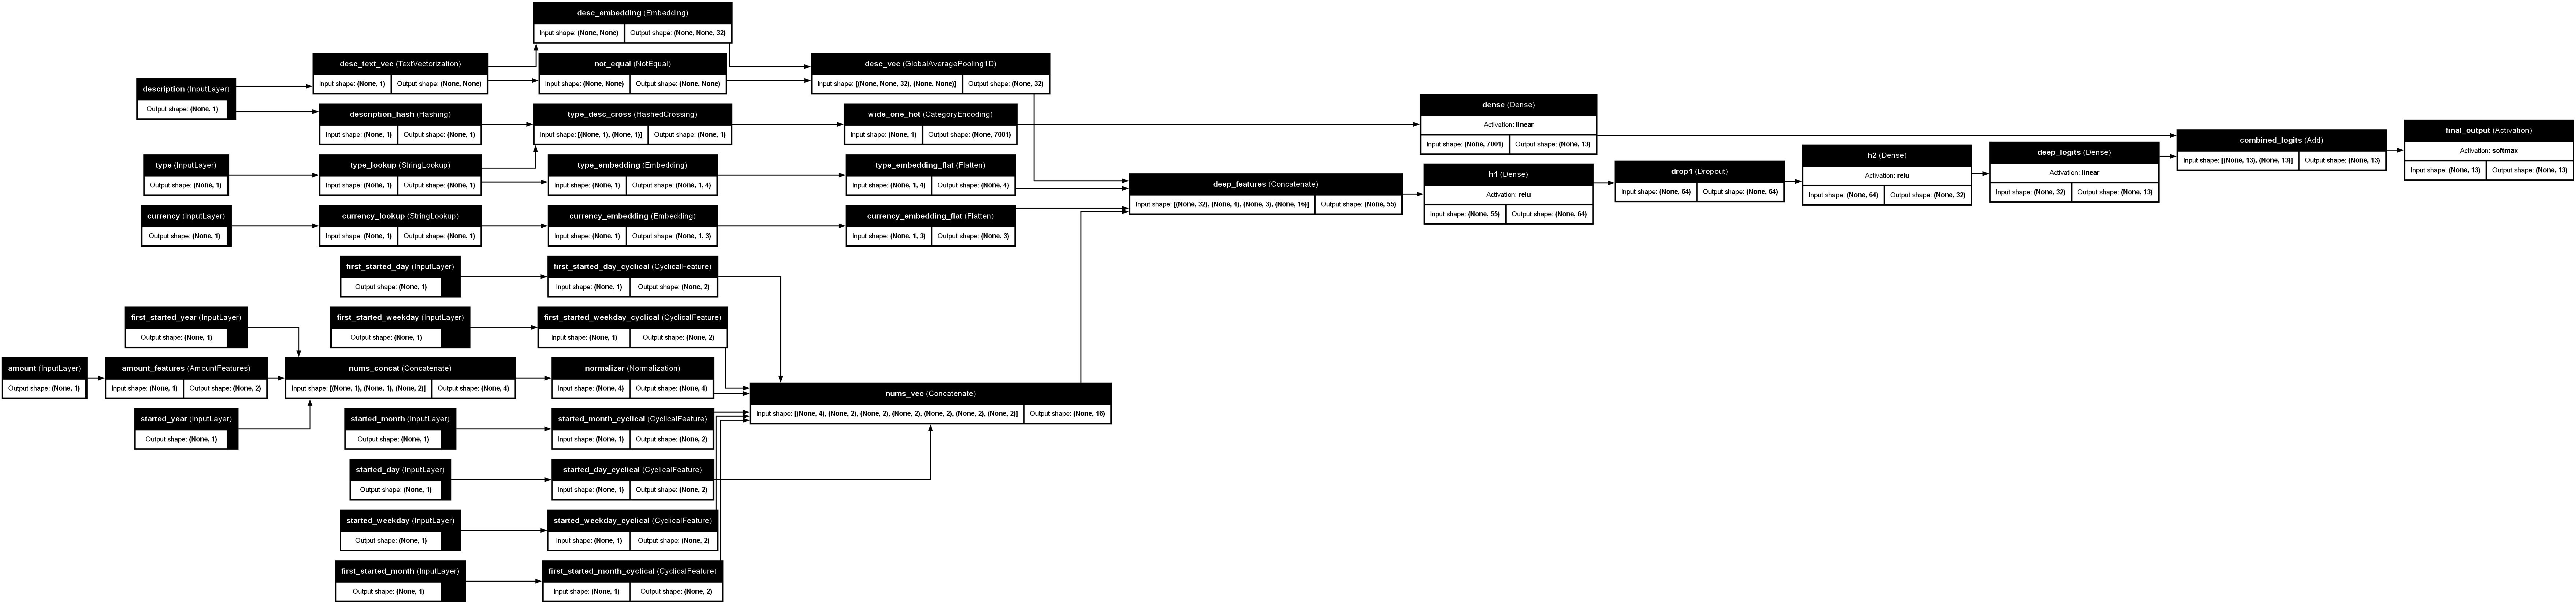

In [37]:
# Generate the plot and save it to a file
plot_model(
    model,
    to_file='i1_model_keras_deep_wide_combined_subclasses.png',
    show_shapes=True,           # This is crucial to see the tensor shapes flow through the model
    show_layer_names=True,      # Shows the names we've been carefully giving each layer
    show_layer_activations=True,# Shows the 'relu' and 'softmax' activations
    rankdir='LR',               # 'TB' for Top-to-Bottom layout. 'LR' is Left-to-Right.
    dpi=96                      # Dots per inch, controls the image resolution.
)

# Model Train

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [39]:
early_stopping = EarlyStopping(monitor='val_loss',  # seen in earlier output, the metric to watch
                               patience=3,          # how many epochs to wait for improvement
                               verbose=1,           # print message when stop
                               restore_best_weights=True)
model_file_name = 'i1_model_keras_deep_wide_combined_subclasses.keras'
model_checkpoint = ModelCheckpoint(filepath=model_file_name,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=100,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
51/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0819 - loss: 2.5816 
Epoch 1: val_loss improved from inf to 2.36251, saving model to i1_model_keras_deep_wide_combined_subclasses.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0950 - loss: 2.5689 - val_accuracy: 0.3924 - val_loss: 2.3625
Epoch 2/100
55/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3815 - loss: 2.3453
Epoch 2: val_loss improved from 2.36251 to 2.12641, saving model to i1_model_keras_deep_wide_combined_subclasses.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3870 - loss: 2.3342 - val_accuracy: 0.4599 - val_loss: 2.1264
Epoch 3/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4547 - loss: 2.0961
Epoch 3: val_loss improved from 2.12641 to 1.84078, saving model to i1_model_keras_deep_wide_combined_subclasses.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4563 - loss: 2.0859 - val_accuracy: 0.4979 - val_loss: 1.8408
Epoch 4/100
52/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

Plot history

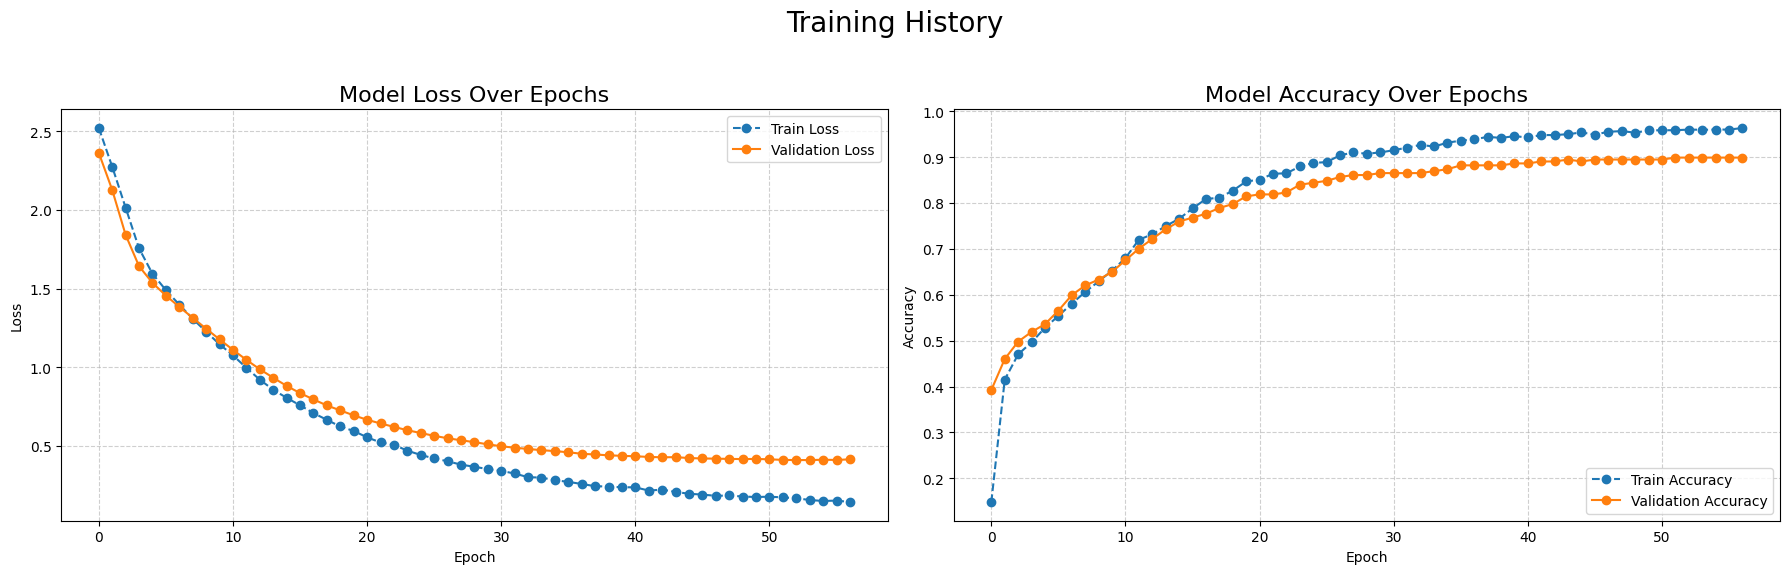

In [40]:

def plot_history(history):
    """Plots the training and validation loss and accuracy."""
    # Create a dataframe from the history object returned by model.fit
    history_df = pd.DataFrame(history.history)

    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- Plot training & validation loss values ---
    ax1.plot(history_df['loss'], label='Train Loss', color='#1f77b4', marker='o', linestyle='--')
    ax1.plot(history_df['val_loss'], label='Validation Loss', color='#ff7f0e', marker='o', linestyle='-')
    ax1.set_title('Model Loss Over Epochs', fontsize=16)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Plot training & validation accuracy values ---
    ax2.plot(history_df['accuracy'], label='Train Accuracy', color='#1f77b4', marker='o', linestyle='--')
    ax2.plot(history_df['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', marker='o', linestyle='-')
    ax2.set_title('Model Accuracy Over Epochs', fontsize=16)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle('Training History', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_history(history)

# Test Prediction

In [41]:
test_ds = df2dataset(test_df, shuffle=False, batch_size=8)
# test if keras model load works
best_model = tf.keras.models.load_model(model_file_name)

# test if TF model dir load works
model_dir_name = 'i1_model_keras_deep_wide_combined_subclasses'
model.export(model_dir_name)
tf.keras.layers.TFSMLayer(
    model_dir_name, 
    call_endpoint='serving_default'
)
#best_model = model
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Converting feature column 'started_year' from Int64 to float32.
Converting feature column 'started_month' from Int64 to float32.
Converting feature column 'started_day' from Int64 to float32.
Converting feature column 'started_weekday' from Int64 to float32.
Converting feature column 'first_started_year' from Int64 to float32.
Converting feature column 'first_started_month' from Int64 to float32.
Converting feature column 'first_started_day' from Int64 to float32.
Converting feature column 'first_started_weekday' from Int64 to float32.
INFO:tensorflow:Assets written to: i1_model_keras_deep_wide_combined_subclasses\assets


INFO:tensorflow:Assets written to: i1_model_keras_deep_wide_combined_subclasses\assets


Saved artifact at 'i1_model_keras_deep_wide_combined_subclasses'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Dict[['started_month', TensorSpec(shape=(None, 1), dtype=tf.float32, name='started_month')], ['started_day', TensorSpec(shape=(None, 1), dtype=tf.float32, name='started_day')], ['started_weekday', TensorSpec(shape=(None, 1), dtype=tf.float32, name='started_weekday')], ['first_started_month', TensorSpec(shape=(None, 1), dtype=tf.float32, name='first_started_month')], ['first_started_day', TensorSpec(shape=(None, 1), dtype=tf.float32, name='first_started_day')], ['first_started_weekday', TensorSpec(shape=(None, 1), dtype=tf.float32, name='first_started_weekday')], ['started_year', TensorSpec(shape=(None, 1), dtype=tf.float32, name='started_year')], ['first_started_year', TensorSpec(shape=(None, 1), dtype=tf.float32, name='first_started_year')], ['amount', TensorSpec(shape=(None, 1), dtype=tf.float64, name='amount')], ['type', TensorSpec(

In [42]:
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([labels.numpy() for features, labels in test_ds], axis=0)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step



--- Classification Report ---
              precision    recall  f1-score   support

    Exchange       1.00      1.00      1.00         3
      PK Abo       0.93      0.87      0.90        15
    PK Artur       0.88      0.64      0.74        22
    PK Kasia       0.57      0.80      0.67         5
    PK Leben       0.95      0.93      0.94        45
     PK Maja       0.50      0.67      0.57        12
    PK Medic       0.67      0.57      0.62         7
   PK Reisen       0.94      0.91      0.93        34
     PK Rest       1.00      0.25      0.40         4
   SK Ferien       0.77      1.00      0.87        17
 SK Haushalt       0.25      0.33      0.29         3
      Top-Up       1.00      1.00      1.00        71
       eShop       0.85      0.92      0.88        12

    accuracy                           0.88       250
   macro avg       0.79      0.76      0.75       250
weighted avg       0.89      0.88      0.88       250


--- Confusion Matrix ---


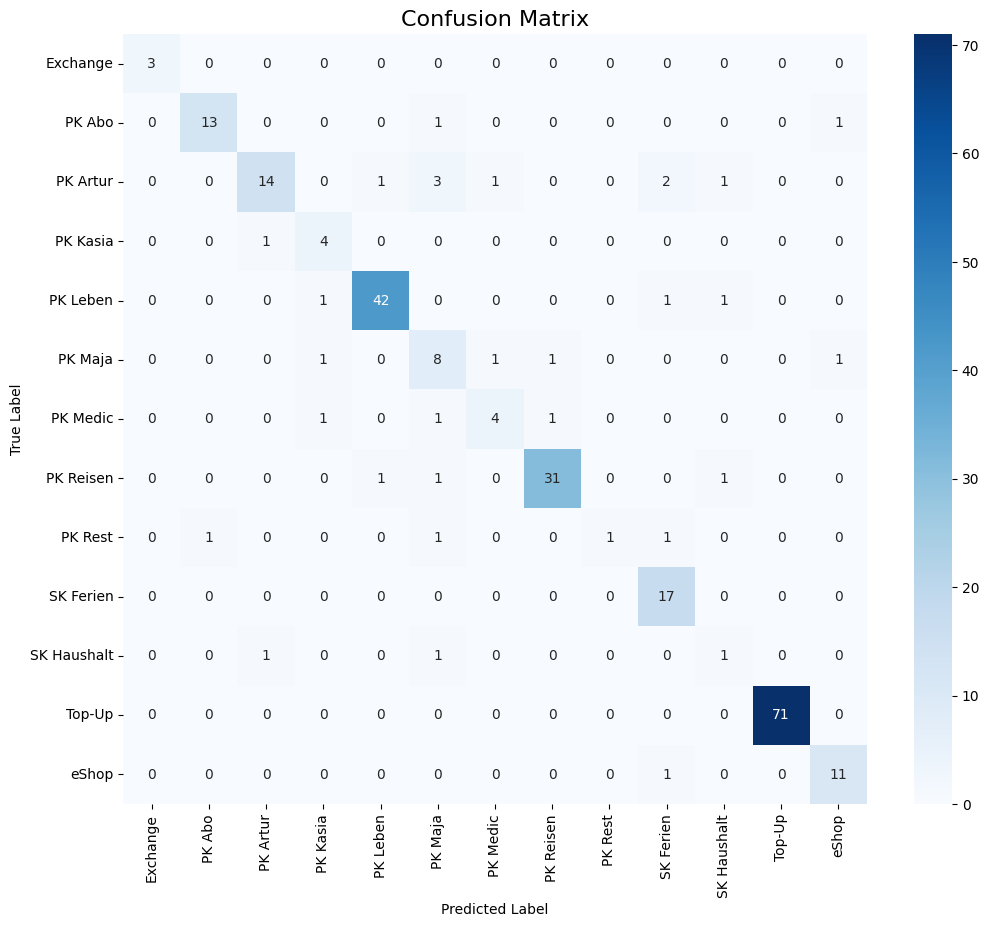

In [43]:
# 4. Print the classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=list(rev_mapping_df.i1_true_label)))

# 5. Plot the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(rev_mapping_df.i1_true_label), 
            yticklabels=list(rev_mapping_df.i1_true_label))
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP